In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
PROJECT_ROOT = Path().resolve()

while not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

# Build correct file path
file_path = PROJECT_ROOT / "data" / "processed" / "nifty50_processed.csv"


In [5]:
df = pd.read_csv(file_path, low_memory=False)
df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Stock
0,0,2010-01-04,55.718451,57.859506,55.183188,57.553642,1860224,ADANIENT.NS
1,1,2010-01-05,57.732052,59.127560,57.732052,58.885418,2280286,ADANIENT.NS
2,2,2010-01-06,59.006477,65.888437,58.624147,64.696838,7326390,ADANIENT.NS
3,3,2010-01-07,66.194331,66.194331,61.555372,62.026913,4759208,ADANIENT.NS
4,4,2010-01-08,62.421990,64.741473,61.453420,62.810696,3324076,ADANIENT.NS
...,...,...,...,...,...,...,...,...
177231,177231,2024-12-24,288.250678,289.844270,283.844884,286.188385,8837902,WIPRO.NS
177232,177232,2024-12-26,286.282136,287.735125,284.969781,285.954041,6516148,WIPRO.NS
177233,177233,2024-12-27,286.094662,291.437828,285.625962,289.750519,8063921,WIPRO.NS
177234,177234,2024-12-30,289.750526,290.031734,283.704280,284.688568,13709891,WIPRO.NS


In [6]:
stock = "RELIANCE.NS"

stock_df = df[df["Stock"] == stock].sort_values("Date")
series = stock_df["Close"].values.reshape(-1,1)

len(series)

3700

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(series)

In [8]:
train_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_size]
test_data  = scaled_data[train_size:]

In [9]:
LOOKBACK = 60

def create_sequences(data, lookback):
    X, y = [], []

    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])

    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, LOOKBACK)
X_test,  y_test  = create_sequences(test_data, LOOKBACK)

print(X_train.shape, y_train.shape)


(2900, 60, 1) (2900, 1)


In [10]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(LOOKBACK,1)))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()


D:\Projects\nifty50-stock-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0043 - val_loss: 6.9125e-04
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.7242e-04 - val_loss: 6.8559e-04
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.6897e-04 - val_loss: 0.0011
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.0776e-04 - val_loss: 0.0050
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.6257e-04 - val_loss: 6.8598e-04
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.7682e-04 - val_loss: 5.6956e-04
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.1383e-04 - val_loss: 8.0965e-04
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 4.8619e-04 - val_loss: 6.3839e-04
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.8175e-04 - val_loss: 5.2698e-04
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.5670e-04 - val_loss: 5.0672e-04
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.1644e-04 - val_loss

In [12]:
predictions = model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [13]:
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test)


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
mae = mean_absolute_error(y_test_real, predictions)

print("LSTM RMSE:", rmse)
print("LSTM MAE :", mae)

LSTM RMSE: 39.83866902546972
LSTM MAE : 32.58116814108456


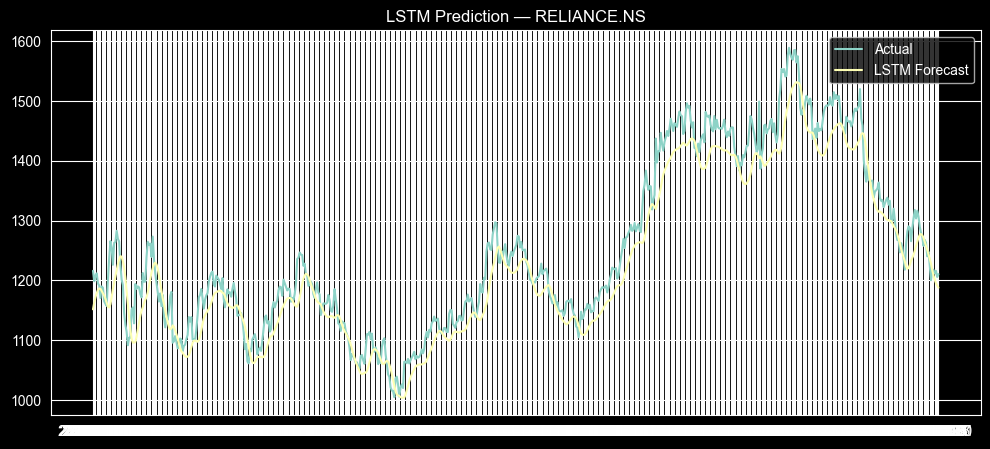

In [15]:
test_dates = stock_df["Date"].iloc[train_size+LOOKBACK:].values

plt.figure(figsize=(12,5))
plt.plot(test_dates, y_test_real, label="Actual")
plt.plot(test_dates, predictions, label="LSTM Forecast")
plt.legend()
plt.title(f"LSTM Prediction — {stock}")
plt.show()


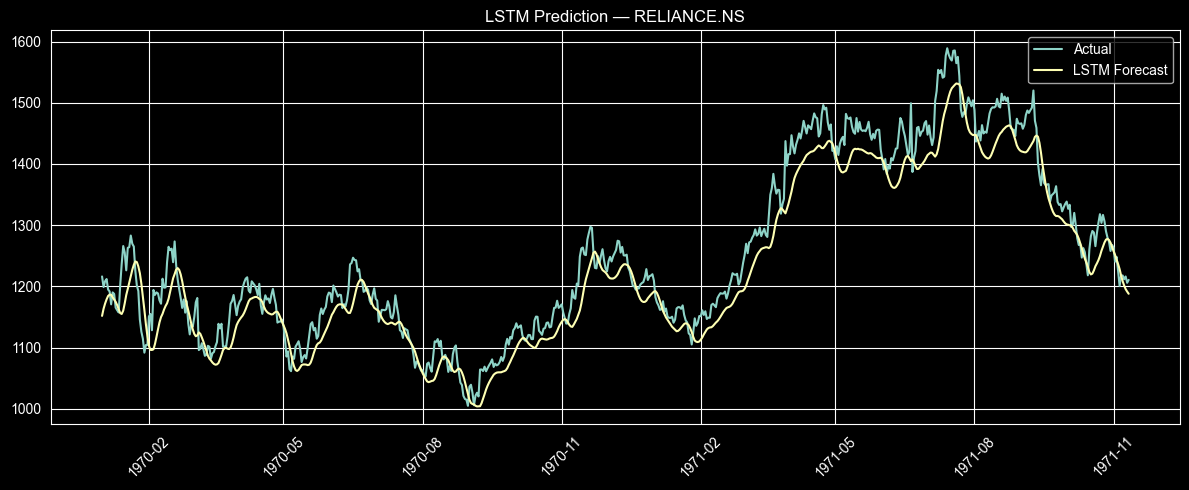

In [16]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.plot(test_dates, y_test_real, label="Actual")
plt.plot(test_dates, predictions, label="LSTM Forecast")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=45)
plt.legend()
plt.title(f"LSTM Prediction — {stock}")
plt.tight_layout()
plt.show()


In [18]:
LOOKBACK = 60

last_window = scaled_data[-LOOKBACK:]
last_window = last_window.reshape(1, LOOKBACK, 1)


In [19]:
FUTURE_DAYS = 30

future_predictions = []

current_window = last_window.copy()

for _ in range(FUTURE_DAYS):

    # predict next value
    next_pred = model.predict(current_window, verbose=0)[0][0]
    future_predictions.append(next_pred)

    # shift window forward
    next_pred_reshaped = np.array(next_pred).reshape(1,1,1)
    current_window = np.concatenate(
        (current_window[:,1:,:], next_pred_reshaped),
        axis=1
    )


In [20]:
future_predictions = np.array(future_predictions).reshape(-1,1)
future_predictions = scaler.inverse_transform(future_predictions)

In [21]:
last_date = stock_df["Date"].iloc[-1]

future_dates = pd.bdate_range(
    start=last_date,
    periods=FUTURE_DAYS+1
)[1:]

C:\Users\HP\AppData\Local\Temp\ipykernel_17328\4240002286.py:10: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000001E6B7E8DBD0>.

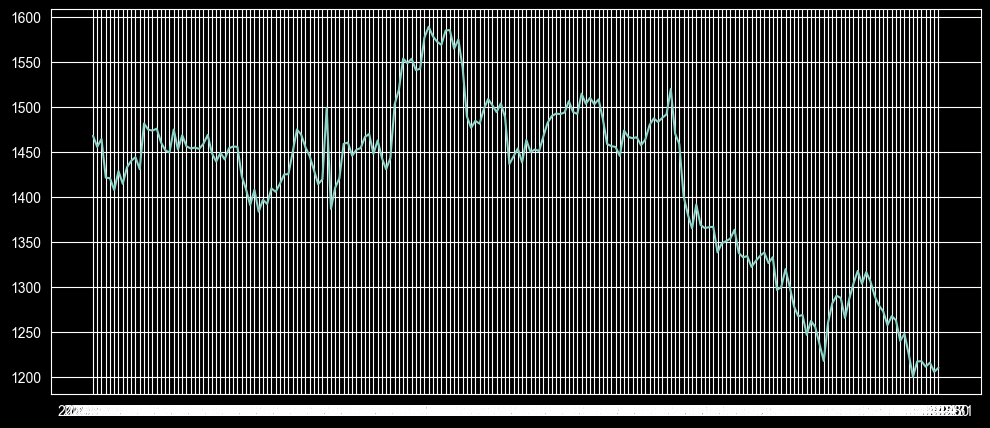

In [22]:
plt.figure(figsize=(12,5))

# last 200 days history for context
plt.plot(
    stock_df["Date"].iloc[-200:],
    stock_df["Close"].iloc[-200:],
    label="Historical Price"
)

plt.plot(
    future_dates,
    future_predictions,
    label="Future Forecast (30 days)",
    color="red"
)

plt.legend()
plt.title(f"LSTM Future 30-Day Forecast — {stock}")
plt.show()


In [23]:
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Price": future_predictions.flatten()
})

forecast_df

,Date,Predicted Price
0,2025-01-01,1185.651367
1,2025-01-02,1181.671875
2,2025-01-03,1176.806763
3,2025-01-06,1171.415039
4,2025-01-07,1165.729614
5,2025-01-08,1159.897461
6,2025-01-09,1154.010864
7,2025-01-10,1148.125122
8,2025-01-13,1142.273682
9,2025-01-14,1136.476196


In [24]:
YEARS = 5
TRADING_DAYS = 252

FUTURE_DAYS = YEARS * TRADING_DAYS

future_predictions = []
current_window = scaled_data[-LOOKBACK:].reshape(1, LOOKBACK, 1)

for _ in range(FUTURE_DAYS):
    next_pred = model.predict(current_window, verbose=0)[0][0]
    future_predictions.append(next_pred)

    current_window = np.append(
        current_window[:,1:,:],
        [[[next_pred]]],
        axis=1
    )

future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1,1)
)


In [25]:
future_dates = pd.bdate_range(
    start=stock_df["Date"].iloc[-1],
    periods=FUTURE_DAYS+1
)[1:]


C:\Users\HP\AppData\Local\Temp\ipykernel_17328\774986647.py:9: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(


TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000001E6ABCD4B00>.

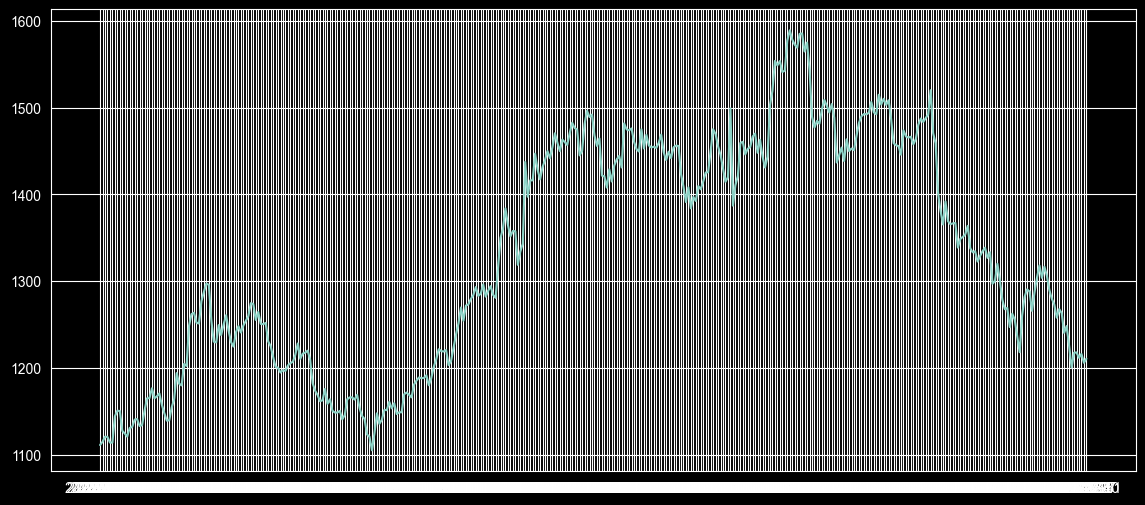

In [26]:
plt.figure(figsize=(14,6))

plt.plot(
    stock_df["Date"].iloc[-400:],
    stock_df["Close"].iloc[-400:],
    label="Recent History"
)

plt.plot(
    future_dates,
    future_predictions,
    label=f"{YEARS} Year Forecast",
    color="red"
)

plt.legend()
plt.title(f"LSTM {YEARS}-Year Price Projection")
plt.show()
